### Real-Data Benchmarking

This notebook goes over a collection of estimators used to model trend (change in mean) across a time series. Specifically a focus is on trend filtering and it's performance in estimation and computation time against splines, kernels, and segmented regression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)

os.listdir(PATH)[:20]

['CNC_reconstructed_features.csv',
 'ABBV_reconstructed_features.csv',
 'BWA_reconstructed_features.csv',
 'GOOG_reconstructed_features.csv',
 'AVGO_reconstructed_features.csv',
 'AME_reconstructed_features.csv',
 'CPT_reconstructed_features.csv',
 'BAX_reconstructed_features.csv',
 'BDX_reconstructed_features.csv',
 'AFL_reconstructed_features.csv',
 'CNP_reconstructed_features.csv',
 'CE_reconstructed_features.csv',
 'ANET_reconstructed_features.csv',
 'APD_reconstructed_features.csv',
 'ADBE_reconstructed_features.csv',
 'BAC_reconstructed_features.csv',
 'AES_reconstructed_features.csv',
 'CHTR_reconstructed_features.csv',
 'ADM_reconstructed_features.csv',
 'CDAY_reconstructed_features.csv']

In [2]:
os.listdir(PATH)

DATA_FILE = "AMZN_reconstructed_features.csv"

In [3]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0,nrows=12000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


### Screening by sale condtion of trades

- Examining only regular trades allows for a much better performace in terms of efficiency and estimation



In [4]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

print("Number of trades: ", len(regular_trades))

Number of trades:  591


In [5]:
trade_data["Sale_Condition"].unique()

array(['@  I', '@F I', '@  Q', '@ TI', '@O X', '@   ', '@F  ', '@4 I',
       '@4 W', '@ ZI', 'R  W'], dtype=object)

### Visualizing Market Data

Plotted below is AMZN trade price and volume data 

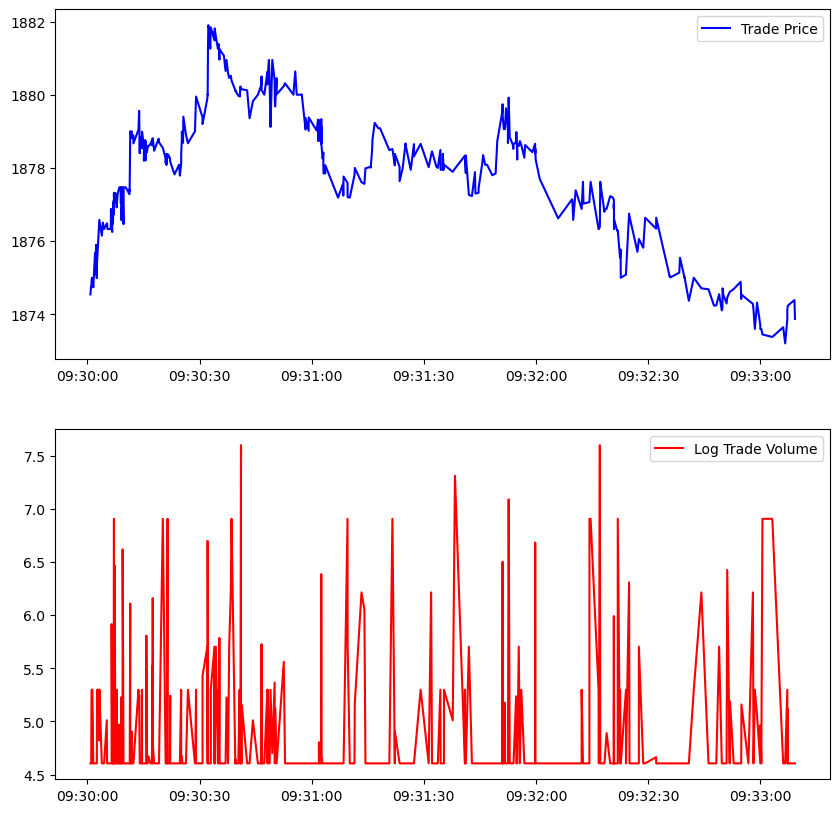

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

trade_price=regular_trades["Trade_Price"]
trade_volume=regular_trades["Trade_Volume"]


ax[0].plot(trade_price, label="Trade Price",color='blue')

ax[1].plot(np.log(trade_volume), label="Log Trade Volume",color='red')

ax[0].legend()
ax[1].legend()

plt.show()



### Quick Performance of Trend Filtering

In [7]:
import sys
sys.path.append("../../")
from estimators.trend_filtering.trend_filter import Trend_Filter

from estimators.cv_base_estimator import cv_base_estimator

In [8]:
x=np.arange(0,len(regular_trades))


tf= Trend_Filter(x=x, y=regular_trades["Trade_Price"].values, k=1, method="primal_dual")

cv_base_estimator(tf)



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 2.603032727851125
Performing cross validation for lambda = 5.025669375870937
Performing cross validation for lambda = 9.703048450112115
Performing cross validation for lambda = 18.733653605875617
Performing cross validation for lambda = 36.16902247054955
Performing cross validation for lambda = 69.83144953981724
Performing cross validation for lambda = 134.82342103115053
Performing cross validation for lambda = 260.3032727851125
Performing cross validation for lambda = 502.56693758709366
Performing cross validation for lambda = 970.3048450112117
Performing cross validation for lambda = 1873.3653605875597
Performing cross validation for lambda = 3616.9022470549553
Performing cross validation for lambda = 6983.144953981725
Performing cross validation for lambda = 13482.342103115041
Performing cross validation for lambda = 26030.32727851125
Performing  1 out of 3 iterations of cross validation
P

{'lambda_': 14.669468669524273}

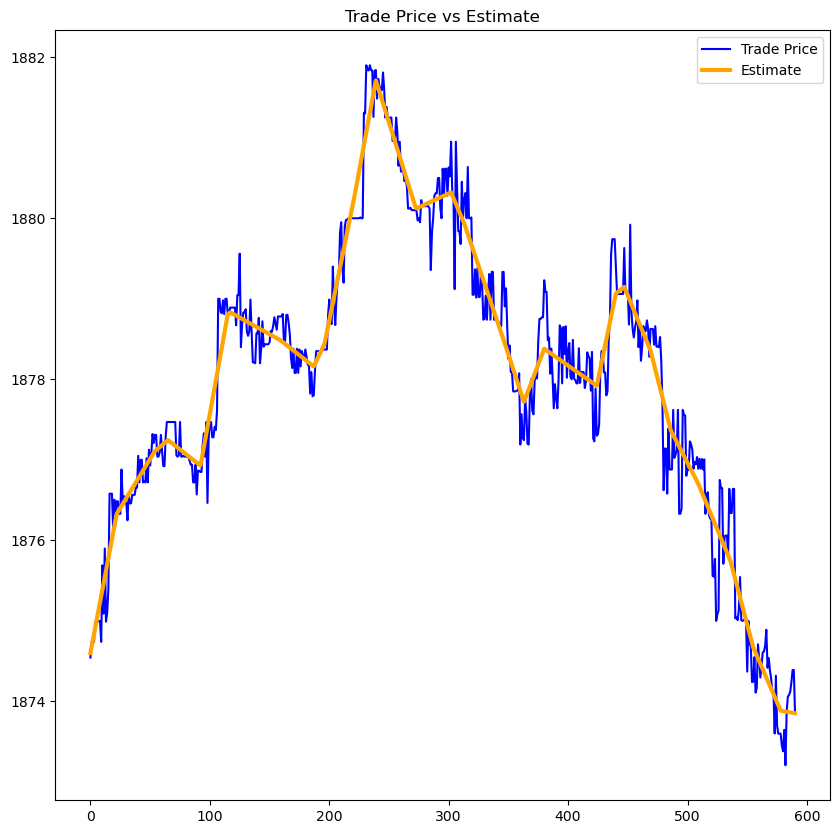

In [9]:


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="Trade Price",color='blue')

ax.plot(tf.y_hat, label="Estimate",lw=3,color='orange')

ax.legend()

ax.set_title("Trade Price vs Estimate")

plt.show()

### Regime Detection from Estimated Trend

In [10]:
from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [11]:
regime_model=Piecewise_Polynomial_Model(x=x, y=tf.y_hat, k=1, method="continous_tf")

[ 21  91 114 195 238 272 301 362 379 423 446 577]
{1: [238], 2: [238, 423], 3: [238, 423, 446], 4: [195, 238, 423, 446], 5: [114, 195, 238, 423, 446], 6: [21, 114, 195, 238, 423, 446], 7: [21, 114, 195, 238, 379, 423, 446], 8: [21, 91, 114, 195, 238, 379, 423, 446], 9: [21, 91, 114, 195, 238, 272, 301, 362, 446], 10: [21, 91, 114, 195, 238, 272, 301, 362, 423, 446], 11: [21, 91, 114, 195, 238, 272, 301, 362, 379, 423, 446], 12: [21, 91, 114, 195, 238, 272, 301, 362, 379, 423, 446, 577], 0: []}
k: 0 mse: 2.9609534120573198
k: 1 mse: 0.8444250748285744
k: 2 mse: 0.5978257781011762
k: 3 mse: 0.46550428316581505
k: 4 mse: 0.4071673664968082
k: 5 mse: 0.29868331703383466
k: 6 mse: 0.233918992959039
k: 7 mse: 0.17591210911238528
k: 8 mse: 0.12743625780284112
k: 9 mse: 0.11891090965695655
k: 10 mse: 0.07601172190181613
k: 11 mse: 0.049096174991650136
k: 12 mse: 0.044892362013052724


In [12]:
regime_model.all_models

{0: 0.28518688318093255,
 1: 0.7079678184858971,
 2: 0.7786621123036166,
 3: 0.8746801720657273,
 4: 0.733563987712596,
 5: 0.7831672531363404,
 6: 0.7520214878113332,
 7: 0.7244314131975172,
 8: 0.9331010789796238,
 9: 0.6392325323311432,
 10: 0.6459026813662683,
 11: 0.9143759574078355}

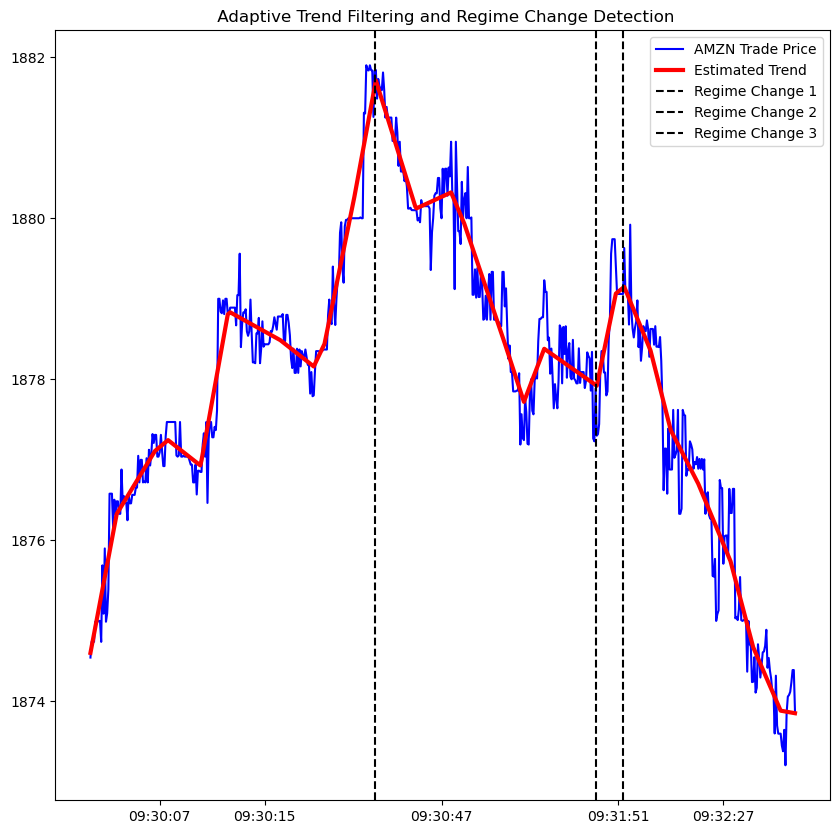

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Estimated Trend ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Ratio of Loss Functions (Used for Model Selection)

In [14]:
model_selection=regime_model.all_models

model_selection

{0: 0.28518688318093255,
 1: 0.7079678184858971,
 2: 0.7786621123036166,
 3: 0.8746801720657273,
 4: 0.733563987712596,
 5: 0.7831672531363404,
 6: 0.7520214878113332,
 7: 0.7244314131975172,
 8: 0.9331010789796238,
 9: 0.6392325323311432,
 10: 0.6459026813662683,
 11: 0.9143759574078355}

Text(0.5, 1.0, 'Model Selection')

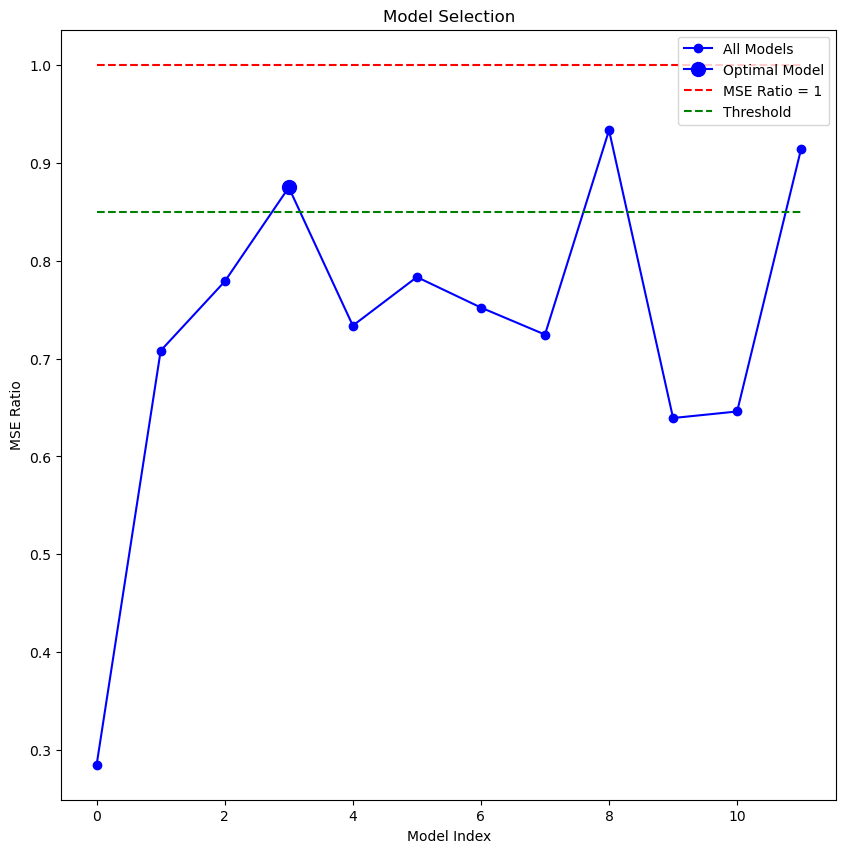

In [15]:
keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i !=regime_model.optimal_model]


nu=regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(regime_model.optimal_model,model_selection[regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")



### Time Dependent Trend Filtering

Careful consideration to round timestamps for observations with near identical timestamps

In [16]:
regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')

round_regular_trades = regular_trades.groupby('Round_Timestamp').agg({'Trade_Price': 'mean', 'Trade_Volume': 'sum'})

round_regular_trades.head()

/tmp/ipykernel_101586/2014949561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')


,Trade_Price,Trade_Volume
Round_Timestamp,,
2020-01-02 09:30:00.820,1874.5450,100.0
2020-01-02 09:30:00.948,1874.7425,200.0
2020-01-02 09:30:01.040,1874.7400,100.0
2020-01-02 09:30:01.160,1874.9900,200.0
2020-01-02 09:30:01.180,1874.9900,200.0


In [17]:
time_trade_price=round_regular_trades["Trade_Price"]

timestamps=round_regular_trades.index-regular_trades.index[0]

timestamps=timestamps.total_seconds().values




In [18]:
time_tf= Trend_Filter(x=timestamps, y=time_trade_price.values, k=1, method="primal_dual")

cv_base_estimator(time_tf)

time_tf.hypers

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 0.3928733250906982
Performing cross validation for lambda = 0.7585196364914216
Performing cross validation for lambda = 1.4644721394873357
Performing cross validation for lambda = 2.8274530337209955
Performing cross validation for lambda = 5.45895715072918
Performing cross validation for lambda = 10.539596172983805
Performing cross validation for lambda = 20.34877439452644
Performing cross validation for lambda = 39.28733250906982
Performing cross validation for lambda = 75.85196364914216
Performing cross validation for lambda = 146.44721394873358
Performing cross validation for lambda = 282.7453033720993
Performing cross validation for lambda = 545.895715072918
Performing cross validation for lambda = 1053.9596172983804
Performing cross validation for lambda = 2034.877439452642
Performing cross validation for lambda = 3928.733250906982
Performing  1 out of 3 iterations of cross validation
Pe

defaultdict(float, {'lambda_': 32.01586255367901})

In [19]:
time_regime_model=Piecewise_Polynomial_Model(x=timestamps, y=time_tf.y_hat, k=1, method="continous_tf")

[ 83 136 171 213 254 294 324 405]
{1: [171], 2: [171, 294], 3: [171, 254, 324], 4: [171, 213, 254, 324], 5: [83, 136, 171, 254, 324], 6: [83, 136, 171, 213, 254, 324], 7: [83, 136, 171, 213, 254, 294, 324], 8: [83, 136, 171, 213, 254, 294, 324, 405], 0: []}
k: 0 mse: 2.7466698096457822
k: 1 mse: 0.5294836556155812
k: 2 mse: 0.3589478151151289
k: 3 mse: 0.17881365982559538
k: 4 mse: 0.17623903603375432
k: 5 mse: 0.15616529105502552
k: 6 mse: 0.1535906672631845
k: 7 mse: 0.1525909851259769
k: 8 mse: 0.15195897052696877


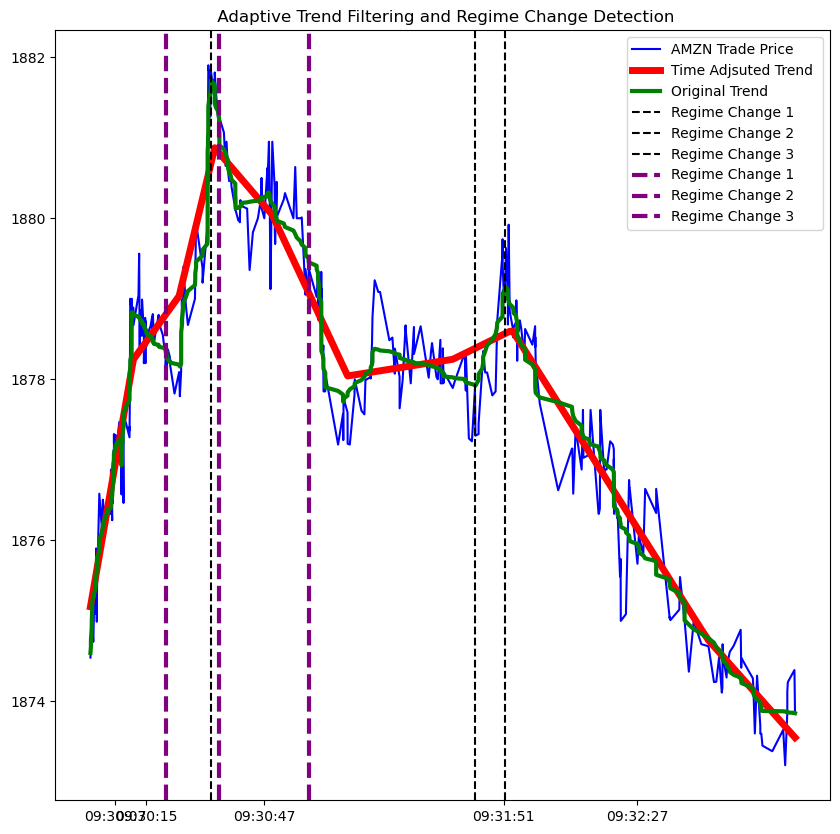

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.index,trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(time_trade_price.index,time_tf.y_hat, label="Time Adjsuted Trend ",color='red',lw=5)
ax.plot(trade_price.index,tf.y_hat, label="Original Trend",color='green',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(trade_price.index[regime_model.knots[i]],color='black',linestyle='--',label=f"Regime Change {i+1}")

for i in range(len(time_regime_model.knots)):
    ax.axvline(trade_price.index[time_regime_model.knots[i]],color='purple',linestyle='--',label=f"Regime Change {i+1}",lw=3)


ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price.values)*q)-1 for q in quantiles]
ax.set_xticks(trade_price.index[indices],regular_trades.index[indices].strftime("%H:%M:%S"))

Text(0.5, 1.0, 'Model Selection')

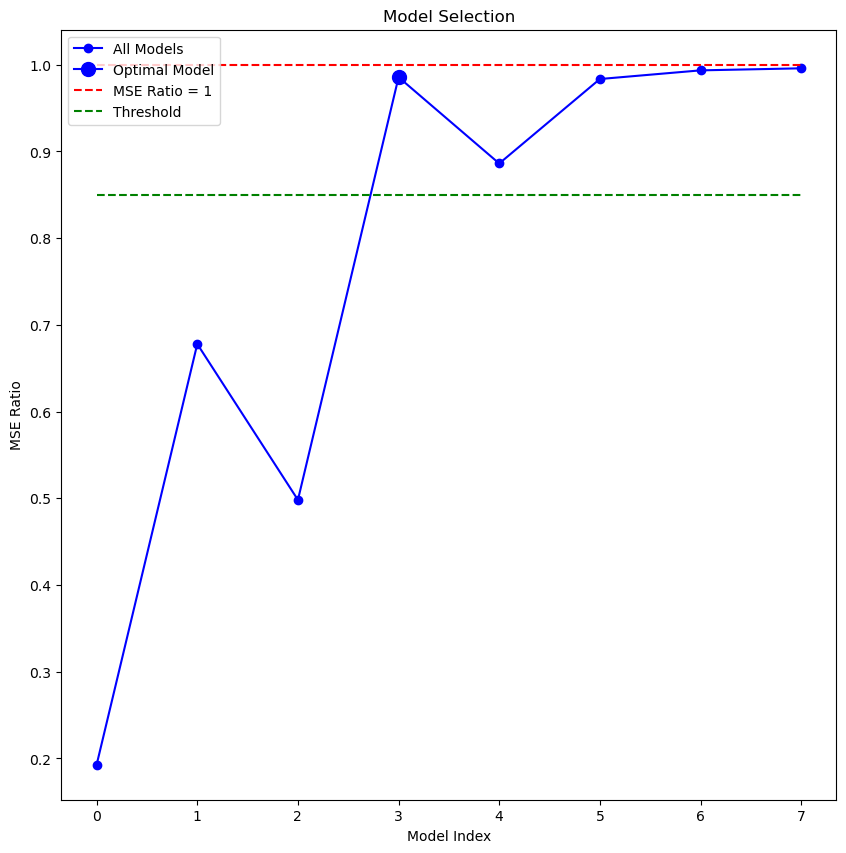

In [21]:
model_selection=time_regime_model.all_models

keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i != time_regime_model.optimal_model]

nu=time_regime_model.nu

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(time_regime_model.optimal_model,model_selection[time_regime_model.optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")
